In [ ]:
import os
import torch
import numpy as np
import math
from functools import partial
import torch
import torch.nn as nn

import ipywidgets as widgets
import io
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch import nn

import warnings
warnings.filterwarnings("ignore")
from CLIP import clip
from ../src/kg_new import kg_load

In [2]:
# def load_clip (device):
#     model, preprocess = clip.load("ViT-B/16", device=device)
#     model_path = '/home/alvi/KG_Defence/mil/models/best_baseline_coco_standard_mil_patch.pt'
#     checkpoint = torch.load(model_path)

#     # Load the model's state_dict
#     model.load_state_dict(checkpoint['model_state_dict'])

#     # Make sure to load the model on the correct device (CPU/GPU)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     return model, preprocess



In [ ]:
def load_model (path,  args):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    args.device = device
    print('--------MODEL PATH--------')
    print(path)

    if (args.dataset == 'coco'):
        kg = kg_load(args)
        classes, kg_dict = kg.load_kg()
    else: 
        classes = None

    model = clip_model(classes=classes, args=args).to(device)

    if (args.distributed_train):
        device_ids = [0]
        model = nn.DataParallel(model, device_ids=device_ids).to(device)
        # model.module.load_state_dict(torch.load(path, map_location=args.device))
        # model.module.eval()
        # return model.module, device
    
        model.load_state_dict(torch.load(path, map_location=args.device))
        model.eval()
        return model.module, device
      

    model.load_state_dict(torch.load(path, map_location=args.device))
    model.eval()

    return model, device

In [9]:
# def transform(img, img_size):
#     img = transforms.Resize(img_size)(img)
#     img = transforms.ToTensor()(img)
#     return img


def visualize_predict(model, img, img_size, patch_size, transform, device):
    img_pre = transform(img)
    attention = visualize_attention(model, img_pre, patch_size, device)
    print('len of attention: ', len(attention))
    print(attention.shape)
    plot_attention(img, attention)


def visualize_attention(model, img, patch_size, device):
    # make the image divisible by the patch size
    w, h = img.shape[1] - img.shape[1] % patch_size, img.shape[2] - \
        img.shape[2] % patch_size
    img = img[:, :w, :h].unsqueeze(0)

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    attentions = model.visual.get_last_selfattention(img.to(device).half())

    nh =  attentions.shape[1]  # number of head

    # keep only the output patch attention
    print('attention shape: ', attentions.shape)
    attentions = attentions[0, :, 0, 1:].reshape(nh, -1)
    print('after attn shape: ', attentions.shape)

    attentions = attentions.reshape(nh, w_featmap, h_featmap)
    attentions = nn.functional.interpolate(attentions.unsqueeze(
        0), scale_factor=patch_size, mode="nearest")[0].cpu().detach().numpy()

    print('after interpolate: ', attentions.shape)
    return attentions


def plot_attention(img, attention):
    n_heads = attention.shape[0] # (6, 640, 960) > (1,400, 6100)
    print('inside plt: ', attention.shape)
    plt.figure(figsize=(10, 10))
    text = ["Original Image", "Head Mean"]
    print(np.mean(attention,0))
    for i, fig in enumerate([img, np.mean(attention, 0)]):
        plt.subplot(1, 2, i+1)
        plt.imshow(fig, cmap='inferno')
        plt.title(text[i])
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(n_heads):
        plt.subplot(n_heads//3, 3, i+1)
        plt.imshow(attention[i], cmap='inferno')
        plt.title(f"Head n: {i+1}")
    plt.tight_layout()
    plt.show()



class Loader(object):
    def __init__(self):
        self.uploader = widgets.FileUpload(accept='image/*', multiple=False)
        self._start()

    def _start(self):
        display(self.uploader)

    def getLastImage(self):
        try:
            for uploaded_filename in self.uploader.value:
                uploaded_filename = uploaded_filename
            img = Image.open(io.BytesIO(
                bytes(self.uploader.value[uploaded_filename]['content'])))

            return img
        except:
            return None

    def saveImage(self, path):
        with open(path, 'wb') as output_file:
            for uploaded_filename in self.uploader.value:
                content = self.uploader.value[uploaded_filename]['content']
                output_file.write(content)


In [10]:
class VitGenerator(object):
    def __init__(self, name_model, patch_size, device, evaluate=True, random=False, verbose=False):
        self.name_model = name_model
        self.patch_size = patch_size
        self.evaluate = evaluate
        self.device = device
        self.verbose = verbose
        self.model, self.preprocess = self._getModel()
        self._initializeModel()
        if not random:
            self._loadPretrainedWeights()

    def _getModel(self):
        
        if self.verbose:
            print(f"[INFO] Initializing {self.name_model} with patch size of {self.patch_size}")
                                
        if self.name_model == 'clip':
            model, preprocess = load_clip(self.device)
        
        else:
            raise f"No model found with {self.name_model}"

        return model, preprocess

    def _initializeModel(self):
        if self.evaluate:
            for p in self.model.parameters():
                p.requires_grad = False

            self.model.eval()

        self.model.to(self.device)

    def _loadPretrainedWeights(self):
        if self.verbose:
            print("[INFO] Loading weights")
        url = None
        if self.name_model == 'vit_small' and self.patch_size == 16:
            url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"

        elif self.name_model == 'vit_small' and self.patch_size == 8:
            url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"

        elif self.name_model == 'vit_base' and self.patch_size == 16:
            url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"

        elif self.name_model == 'vit_base' and self.patch_size == 8:
            url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
        
        elif self.name_model == 'clip/32':
            url = "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt"
        elif self.name_model == 'clip/16':
            url = "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt"

        if url is None:
            print(
                f"Since no pretrained weights have been found with name {self.name_model} and patch size {self.patch_size}, random weights will be used")

        else:
            state_dict = torch.hub.load_state_dict_from_url(
                url=url)
            self.model.load_state_dict(state_dict, strict=True)

    def get_last_selfattention(self, img):
        return self.model.get_last_selfattention(img.to(self.device))

    def __call__(self, x):
        return self.model(x)

here vit
inside prepare tokens
before conv1 torch.Size([1, 3, 224, 224])
after conv1 shape:  torch.Size([1, 768, 14, 14])
before cat torch.Size([1, 196, 768])
pos emb:  torch.Size([1, 197, 768])
after pre: torch.Size([1, 197, 768])
before attn shape:  torch.Size([1, 197, 768]) torch.Size([1, 197, 768])
atten weights:  torch.Size([1, 12, 197, 197])
before attn shape:  torch.Size([1, 197, 768]) torch.Size([1, 197, 768])
atten weights:  torch.Size([1, 12, 197, 197])
before attn shape:  torch.Size([1, 197, 768]) torch.Size([1, 197, 768])
atten weights:  torch.Size([1, 12, 197, 197])
before attn shape:  torch.Size([1, 197, 768]) torch.Size([1, 197, 768])
atten weights:  torch.Size([1, 12, 197, 197])
before attn shape:  torch.Size([1, 197, 768]) torch.Size([1, 197, 768])
atten weights:  torch.Size([1, 12, 197, 197])
before attn shape:  torch.Size([1, 197, 768]) torch.Size([1, 197, 768])
atten weights:  torch.Size([1, 12, 197, 197])
before attn shape:  torch.Size([1, 197, 768]) torch.Size([1,

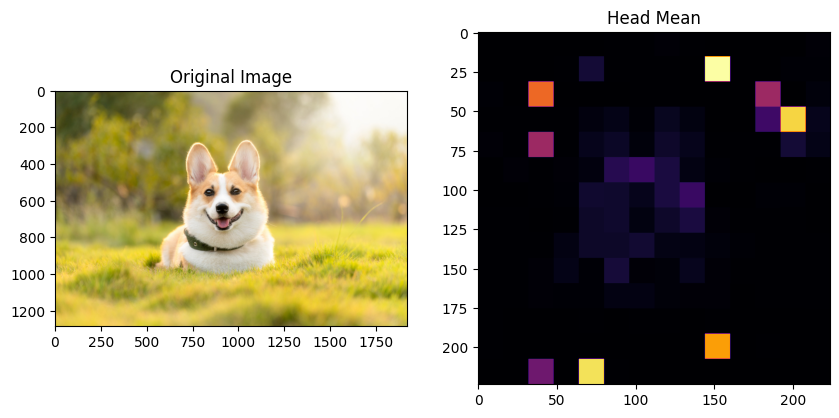

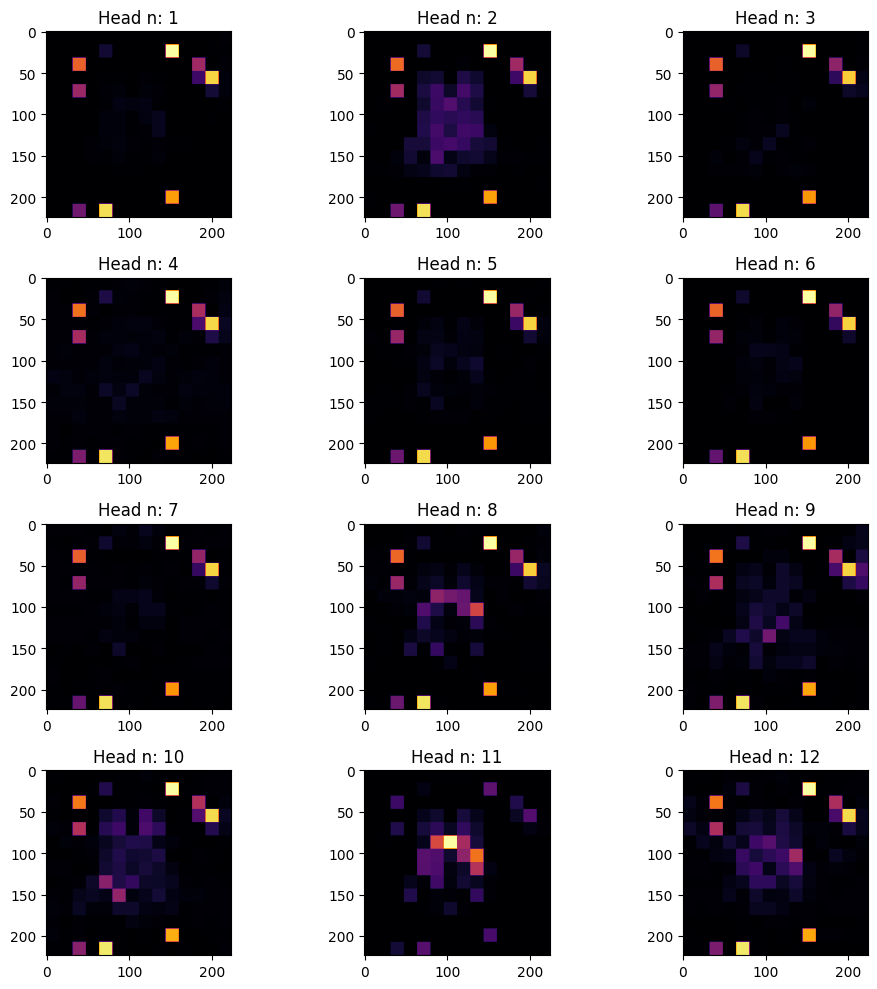

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if device.type == "cuda":
    torch.cuda.set_device(3)

name_model = 'clip/16'
patch_size = 16


model, preprocess = load_clip(device)
# print(model)

# model, preprocess = VitGenerator(name_model, patch_size, 
#                      device, evaluate=True, random=False, verbose=True)





# # Visualizing Dog Image
path = '/home/grads/alvi/KG_Defence/corgi_image.jpg'
img = Image.open(path)
factor_reduce = 2
img_size = tuple(np.array(img.size[::-1]) // factor_reduce) 
visualize_predict(model, img, img_size, patch_size, preprocess, device)